In [1]:
import numpy as np
import pylab as plt
import torch
import scipy.stats as stats
import scipy
import numpy as np
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import swyft
import random
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch.optim as optim
from torch.utils.data import TensorDataset, Dataset, DataLoader



DEVICE = 'gpu' if torch.cuda.is_available() else 'cpu'

# Define simulator parameters
f_low = 10
f_high = 1024
N_bins = 4076
freq = np.linspace(f_low, f_high, N_bins)
pi = np.pi
sqrt = np.sqrt
H100 = 3.241e-18
h    = 0.679
H0   = h * H100

bounds=[
    [1e-10,1e-7], # omega 
        [0,1]
        ] # alpha


# Define Simulator
class Simulator(swyft.Simulator):
    def __init__(self, fref, psd, gamma, T_obs, Nbins=len(freq), bounds=bounds):
        super().__init__()
        
        self.fref      = fref
        self.psd       = psd
        self.gamma     = gamma
        self.T_obs     = T_obs
        
       
        self.Nbins = Nbins
        self.freq = np.linspace(f_low, f_high, N_bins)


        # Use the bounds argument to define the RectBoundSampler
        # Convert the bounds from a list of tuples to arrays
        self.sample_z = swyft.RectBoundSampler(
            [
                stats.loguniform(bounds[0][0], bounds[0][1]),  # omega bounds
                stats.uniform(bounds[1][0], bounds[1][1]-bounds[1][0])   # alpha bounds
            ],
            bounds=np.array(bounds)  # Convert bounds to numpy array
        )


    def psd_interp(self):
        return scipy.interpolate.interp1d(self.psd[:,0], self.psd[:,1])(self.freq)
    
    def gamma_interp(self):
        return scipy.interpolate.interp1d(self.gamma[:, 0], self.gamma[:, 1])(self.freq)
    
    def sigma(self):
        numerator = (20*pi**2*self.freq**3)**2 * self.psd_interp()**2
        denomenator = (3*H0**2)**2 * 8*self.gamma_interp()**2
        T = 1/(self.freq[1]-self.freq[0])
        N = 2*self.T_obs // T - 1
        return np.sqrt(numerator/denomenator/N)
    
    def C_groundtruth(self, z):
        Omega_ref = 10**z[0]
        alpha     = z[1]
        C_hat_ij = Omega_ref * (self.freq/self.fref)**alpha
        return C_hat_ij
    
    def build(self, graph):
    
        z = graph.node('z', lambda: self.sample_z())
        m = graph.node('m', lambda z: self.C_groundtruth(z), z)
        x = graph.node("x", lambda m: m + np.random.normal(0, self.sigma()), m)
        sigma = graph.node('sigma', lambda: self.sigma())


In [2]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        # Encoder layers (same as before, but with mu and logvar layers)
        self.encoder_fc1 = nn.Linear(4076, 2048)
        self.encoder_fc2 = nn.Linear( 2048, 1024)
        self.encoder_fc3 = nn.Linear(1024, 512)
        self.encoder_fc4 = nn.Linear(512, 256)
        self.encoder_fc5 = nn.Linear( 256, 128)
        self.encoder_fc6 = nn.Linear(128, 64)
        self.encoder_fc7 = nn.Linear(64, 32)
        
        # Latent space mean and log variance
        self.fc_mu = nn.Linear(32,16) # bigger latent space improved learning 
        self.fc_logvar = nn.Linear(32, 16)

        # Decoder layers
        
        self.decoder_fc1 = nn.Linear(16,32)
        self.decoder_fc2 = nn.Linear(32, 64)
        self.decoder_fc3 = nn.Linear(64, 128)
        self.decoder_fc4 = nn.Linear(128, 256)
        self.decoder_fc5 = nn.Linear(256, 512)
        self.decoder_fc6 = nn.Linear(512, 1024)
        self.decoder_fc7 = nn.Linear(1024, 2048)
        self.decoder_fc8 = nn.Linear(2048, 4076)
        

        self.dropout = nn.Dropout(0.2)

    def encode(self, x):
        # Encode input to latent space
        x = F.leaky_relu(self.encoder_fc1(x))
        x = F.leaky_relu(self.encoder_fc2(x))
        x = F.leaky_relu(self.encoder_fc3(x))
        x = F.leaky_relu(self.encoder_fc4(x))
        x = F.leaky_relu(self.encoder_fc5(x))
        x = F.leaky_relu(self.encoder_fc6(x))
        x = F.leaky_relu(self.encoder_fc7(x))
       
    
        # Get the mean and log variance for the latent space
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)

        return mu, logvar

    def reparameterize(self, mu, logvar):
        # Reparameterization trick: z = mu + sigma * epsilon
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std) # random noise
        z = mu + eps * std # latent variable
        return z

    def decode(self, z):
        # Decode the sampled latent vector
        z = F.leaky_relu(self.decoder_fc1(z))
        z = F.leaky_relu(self.decoder_fc2(z))
        z = F.leaky_relu(self.decoder_fc3(z))
        z = F.leaky_relu(self.decoder_fc4(z))
        z = F.leaky_relu(self.decoder_fc5(z))
        z = F.leaky_relu(self.decoder_fc6(z))
        z = F.leaky_relu(self.decoder_fc7(z))

        z = self.decoder_fc8(z) #no activation for log10 data
        return z

    def forward(self, x):
        # Forward pass: encode, reparameterize, decode
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        z = self.dropout(z)
        x_reconstructed = self.decode(z)
        return x_reconstructed, mu, logvar
    



In [3]:
# Sample from Simulator

n_samples = 10000
fref = 25
CE_PSD = np.genfromtxt("data/cosmic_explorer_40km_for_paper.txt")
CE_PSD[0, 0]  = 4.99999999999999999
CE_PSD[:, 1] = CE_PSD[:, 1]**2
gamma_HL = np.genfromtxt("data/gamma_HL.txt")
T_obs = 365 * 24 * 3600

sim = Simulator(fref, CE_PSD, gamma_HL, T_obs)
obs = sim.sample(conditions = {'z': np.array([-7.3, 2.1])})


In [4]:
# Instantiate variational autoencoder 
vae = VAE()
# load pretrained model
model = torch.load('VAE_model_pytorch_V2.pt')
vae.eval()

/var/folders/63/39kkwt414rv8gx91d72hdt240000gn/T/ipykernel_22028/3312582178.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('VAE_model_pytorch_V2.pt')

VAE(
  (encoder_fc1): Linear(in_features=4076, out_features=2048, bias=True)
  (encoder_fc2): Linear(in_features=2048, out_features=1024, bias=True)
  (encoder_fc3): Linear(in_features=1024, out_features=512, bias=True)
  (encoder_fc4): Linear(in_features=512, out_features=256, bias=True)
  (encoder_fc5): Linear(in_features=256, out_features=128, bias=True)
  (encoder_fc6): Linear(in_features=128, out_features=64, bias=True)
  (encoder_fc7): Linear(in_features=64, out_features=32, bias=True)
  (fc_mu): Linear(in_features=32, out_features=16, bias=True)
  (fc_logvar): Linear(in_features=32, out_features=16, bias=True)
  (decoder_fc1): Linear(in_features=16, out_features=32, bias=True)
  (decoder_fc2): Linear(in_features=32, out_features=64, bias=True)
  (decoder_fc3): Linear(in_features=64, out_features=128, bias=True)
  (decoder_fc4): Linear(in_features=128, out_features=256, bias=True)
  (decoder_fc5): Linear(in_features=256, out_features=512, bias=True)
  (decoder_fc6): Linear(in_fea

In [5]:
class VAEEstimator(swyft.SwyftModule):
    def __init__(self, vae):
        super().__init__()
        self.vae = vae
        self.latent_dim = 16  
        self.logratios = swyft.LogRatioEstimator_Ndim(
            num_features=self.latent_dim,
            marginals=[(0, 1)],
            varnames='z',
            num_blocks=4
        )

    def forward(self, A, B):
        with torch.no_grad():  # Freeze VAE during inference
            mu, logvar = self.vae.encode(A['x'])
            z = self.vae.reparameterize(mu, logvar)
            z = self.vae.dropout(z)
        return self.logratios(z, B['z'])

In [6]:
#implement T M N R E 

def round(fref, CE_PSD, gamma_HL, T_obs, vae, n_samples, Nbins=4076,  bounds=None):
 
    # Initialize the simulator
    sim = Simulator(fref, CE_PSD, gamma_HL, T_obs, bounds= bounds)
    samples = sim.sample(n_samples)

    # Preprocess log10 and standard scale
    x_samples = np.log10(np.abs(samples['x']))
    scaler_x = StandardScaler()
    x_samples = scaler_x.fit_transform(x_samples)
    samples['x'] = x_samples

    # Select observation
    obs = swyft.Sample(x=samples['x'][0], z=samples['z'][0]) 
    
    # Training the model
    dm = swyft.SwyftDataModule(samples, batch_size=32)
    network = VAEEstimator(vae)
    trainer = swyft.SwyftTrainer(accelerator=DEVICE, precision=64)
    trainer.fit(network, dm)

    # Sample prior 
    prior_samples = sim.sample(n_samples, targets = ['z'])
    # Perform inference
    predictions = trainer.infer(network, obs, prior_samples)

    # Update bounds 
    new_bounds = swyft.collect_rect_bounds(predictions, 'z', parshape=(2,), threshold=1e-4)


    return predictions, new_bounds, samples, obs


  0%|          | 0/10000 [00:00<?, ?it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/lexington/anaconda3/envs/test_env/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(
/Users/lexington/anaconda3/envs/test_env/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
  warning_cache.warn(
/Users/lexi

Sanity Checking: 0it [00:00, ?it/s]

/Users/lexington/anaconda3/envs/test_env/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/lexington/anaconda3/envs/test_env/lib/python3.11/site-packages/torch/__init__.py:1144: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:434.)
  _C._set_default_tensor_type(t)
/Users/lexington/anaconda3/envs/test_env/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataload

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Reloading best model: /Users/lexington/Documents/GitHub/SBI_SGWB_DSMMA/Lexi/lightning_logs/version_368/checkpoints/epoch=2-step=750.ckpt


/Users/lexington/anaconda3/envs/test_env/lib/python3.11/site-packages/swyft/lightning/utils.py:535: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(sel

  0%|          | 0/10000 [00:00<?, ?it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint


Predicting: 250it [00:00, ?it/s]

/Users/lexington/anaconda3/envs/test_env/lib/python3.11/site-packages/pytorch_lightning/loops/epoch/prediction_epoch_loop.py:173: UserWarning: Lightning couldn't infer the indices fetched for your dataloader.
  warning_cache.warn("Lightning couldn't infer the indices fetched for your dataloader.")


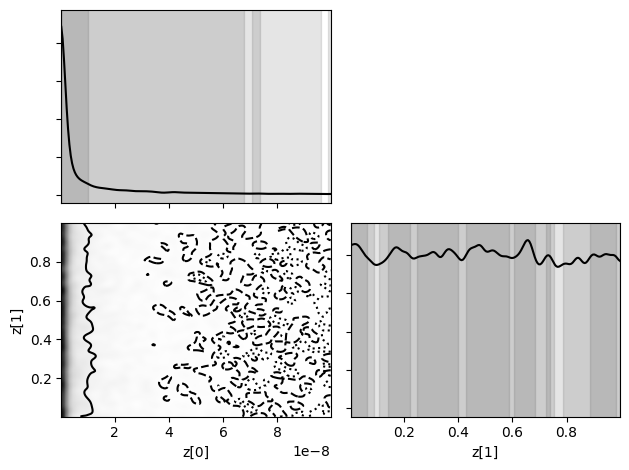

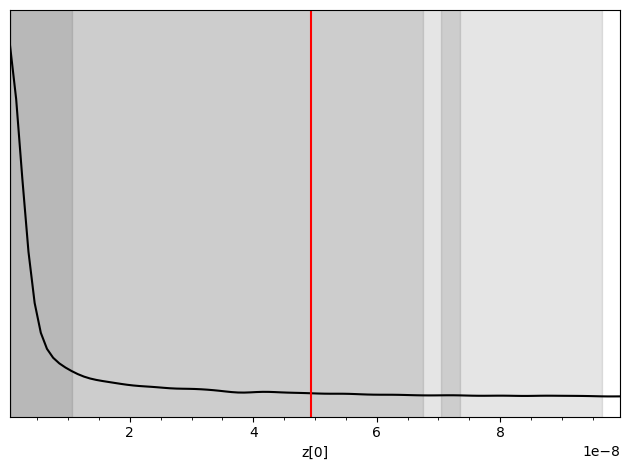

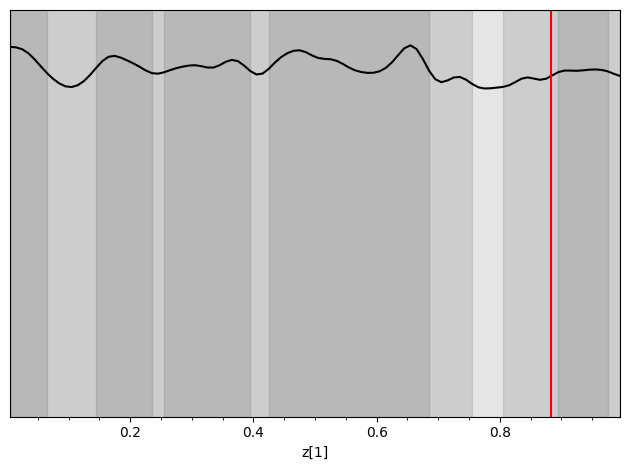

tensor([[1.0005e-10, 9.9899e-08],
        [5.7482e-05, 9.9993e-01]], dtype=torch.float64)


  0%|          | 0/10000 [00:00<?, ?it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/lexington/anaconda3/envs/test_env/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(
/Users/lexington/anaconda3/envs/test_env/lib/python3.11/site-packages/pytorch_lightning/loops/utilities.py:94: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint

  | Name      | Type                   | Params
-----------------------------------------------------
0 | vae       | VAE                    | 22.3 M
1 | logratios | LogRatioEstimator_Ndim | 35.6 K
--

Sanity Checking: 0it [00:00, ?it/s]

/Users/lexington/anaconda3/envs/test_env/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/lexington/anaconda3/envs/test_env/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Reloading best model: /Users/lexington/Documents/GitHub/SBI_SGWB_DSMMA/Lexi/lightning_logs/version_369/checkpoints/epoch=3-step=1000.ckpt


/Users/lexington/anaconda3/envs/test_env/lib/python3.11/site-packages/swyft/lightning/utils.py:535: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(sel

  0%|          | 0/10000 [00:00<?, ?it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint


Predicting: 250it [00:00, ?it/s]

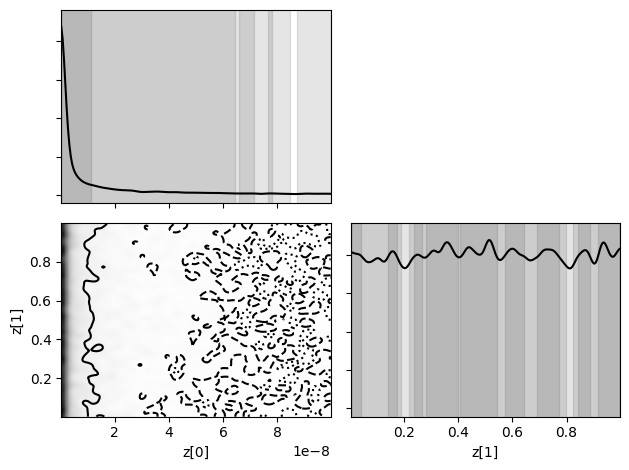

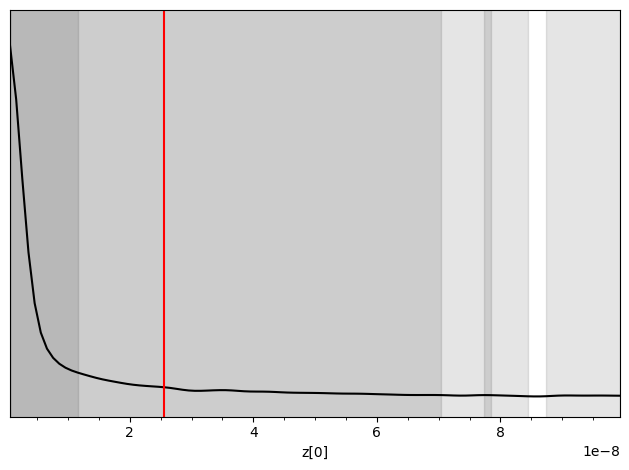

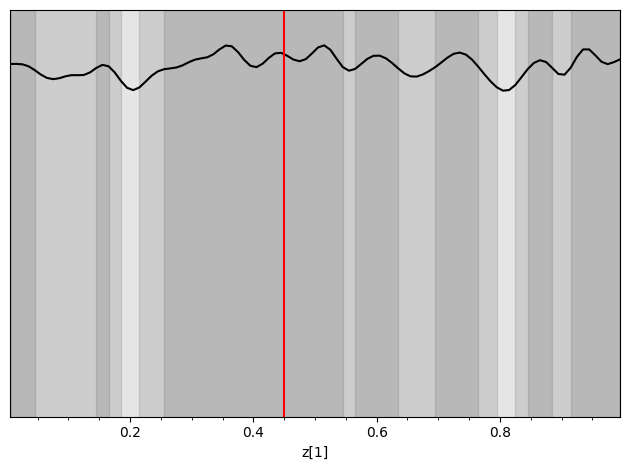

tensor([[1.0018e-10, 9.9860e-08],
        [1.3106e-04, 9.9987e-01]], dtype=torch.float64)


  0%|          | 0/10000 [00:00<?, ?it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/lexington/anaconda3/envs/test_env/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(
/Users/lexington/anaconda3/envs/test_env/lib/python3.11/site-packages/pytorch_lightning/loops/utilities.py:94: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint

  | Name      | Type                   | Params
-----------------------------------------------------
0 | vae       | VAE                    | 22.3 M
1 | logratios | LogRatioEstimator_Ndim | 35.6 K
--

Sanity Checking: 0it [00:00, ?it/s]

/Users/lexington/anaconda3/envs/test_env/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/lexington/anaconda3/envs/test_env/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Reloading best model: /Users/lexington/Documents/GitHub/SBI_SGWB_DSMMA/Lexi/lightning_logs/version_370/checkpoints/epoch=3-step=1000.ckpt


/Users/lexington/anaconda3/envs/test_env/lib/python3.11/site-packages/swyft/lightning/utils.py:535: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(sel

  0%|          | 0/10000 [00:00<?, ?it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint


Predicting: 250it [00:00, ?it/s]

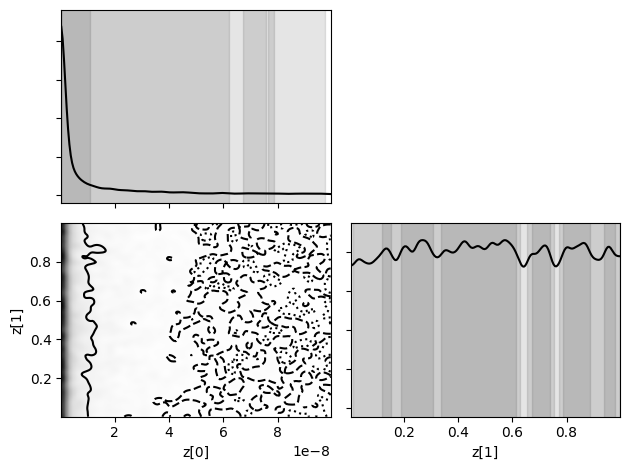

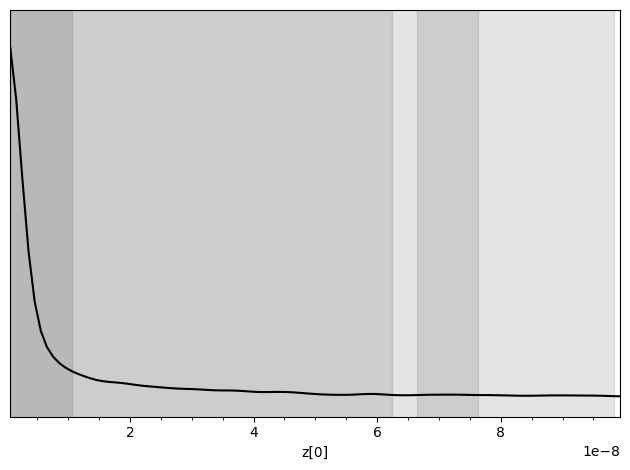

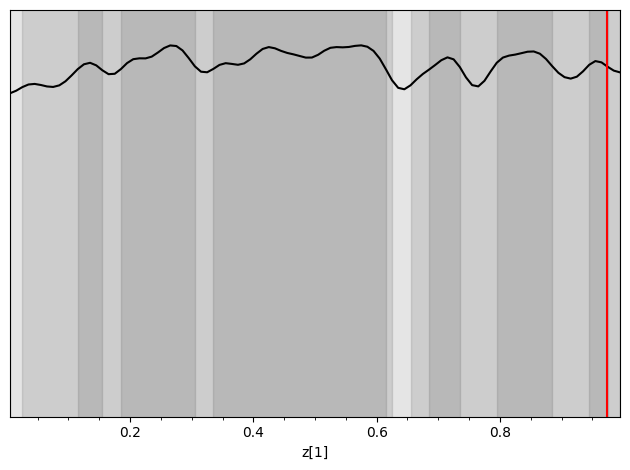

tensor([[1.0048e-10, 9.9792e-08],
        [1.6314e-04, 9.9985e-01]], dtype=torch.float64)


In [7]:

vae = VAE()
n_samples = 10000

prediction_rounds = []
bounds_rounds = []
bounds_alpha_rounds = []
samples_rounds = []
n_rounds = 2


for n in range(n_rounds):

    
  # Call the round function to perform TMNRE
  predictions, bounds, samples, obs = round(fref, CE_PSD, gamma_HL, T_obs, vae, n_samples, Nbins=4076,  bounds=bounds
        )
  swyft.plot_corner(predictions, ['z[0]', 'z[1]'], bins = 200, smooth = 3);
  plt.show()
  swyft.plot_posterior(predictions, 'z[0]', smooth=2);
  plt.axvline(obs['z'][0], color="red")
  plt.show()

  swyft.plot_posterior(predictions, 'z[1]', smooth=2);
  plt.axvline(obs['z'][1], color="red")
  plt.show()

    #plot_posterior(predictions, samples, sim)
 
  plt.show()
  print(bounds)
  prediction_rounds.append(predictions)
  bounds_rounds.append(bounds)
  #bounds_alpha_rounds.append(bounds_alpha)
  samples_rounds.append(samples)
  

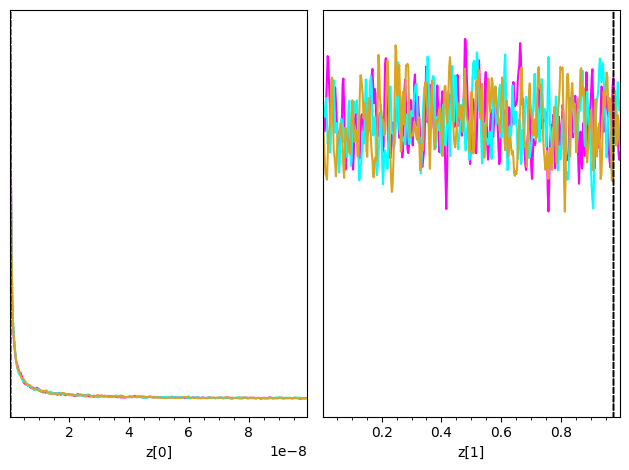

In [8]:
obs = swyft.Sample(x=samples['x'][0], z=samples['z'][0] ) 
truth = {k: v for k, v in zip(["z[%i]"%i for i in range(2)], obs['z'])}
colors = ['fuchsia', 'cyan', 'goldenrod']
fig = None
for i in range(n_rounds):
    fig = swyft.plot_posterior(prediction_rounds[i], ["z[%i]"%i for i in range(2)], fig=fig, truth=truth, smooth = 1, bins = 400, contours = False, color=colors[i])
#plt.legend()
plt.show()

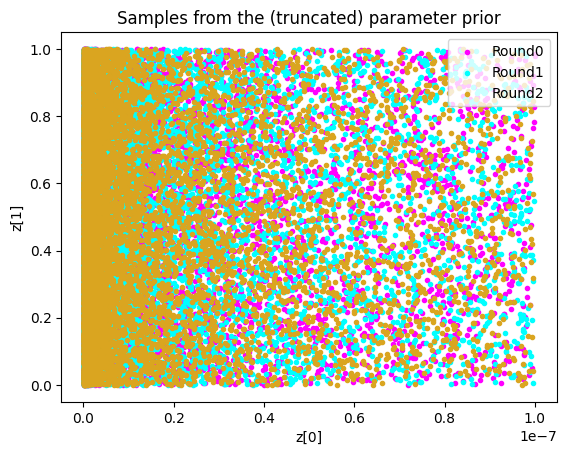

In [9]:


for i in range(n_rounds): 

    plt.scatter(samples_rounds[i]['z'][:,0], samples_rounds[i]['z'][:,1], color = colors[i], label = ('Round'+str(i)), marker = '.')
   
#plt.scatter(obs['z'][0], obs['z'][1], marker = 'x', color='k', label = 'Truth')
plt.legend()
plt.xlabel("z[0]"); plt.ylabel("z[1]")
plt.title("Samples from the (truncated) parameter prior");

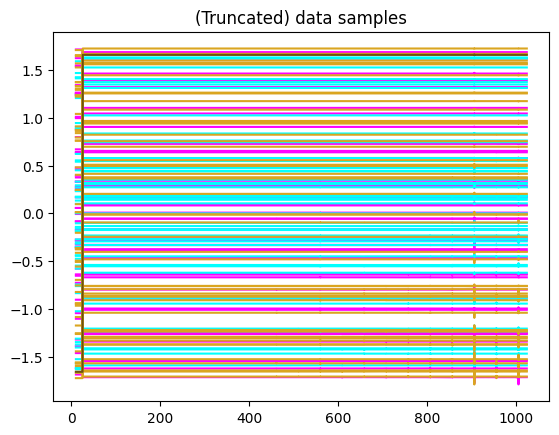

In [10]:
for i in range(0, n_rounds):
    for j in range(50):
        plt.plot(sim.freq, samples_rounds[i]['x'][j], color =colors[i])
plt.plot(sim.freq, obs['x'], color = 'k', alpha = 0.5)
#plt.ylim([-1, 1])
plt.title("(Truncated) data samples");

In [11]:
"""
# Define priors with best bounds
bounds_rounds = np.asarray(bounds_rounds)
omega_prior = stats.uniform(bounds_rounds[-1][0][0], bounds_rounds[-1][0][1])  # Log-uniform distribution for omega
alpha_prior = stats.uniform(bounds_rounds[-1][1][0], bounds_rounds[-1][1][1])            # Uniform distribution for alpha
obs = swyft.Sample(x=samples['x'][0], z=samples['z'][0] ) 
# Sample from the priors
z_omega = omega_prior.rvs(20000)
z_alpha = alpha_prior.rvs(20000)
z_samps = np.column_stack((z_omega, z_alpha))


import seaborn as sns
ln_r = np.asarray(prediction_rounds[:0][0].logratios)
r_1 = np.exp(ln_r[:, 0])
r_2 = np.exp(ln_r[:, 1])
post_Omega = np.random.choice(z_samps[:, 0], size=1000, p = r_1/np.sum(r_1))
post_alpha = np.random.choice(z_samps[:, 1], size=1000, p = r_2/np.sum(r_2))

plt.figure(figsize=(15, 6))
plt.subplot(131)
sns.histplot(post_Omega, bins=30, element="step", fill=False)
plt.axvline(obs['z'][0], color="red")
plt.xlabel(r"$\log_{10}\Omega_\alpha$")
plt.subplot(132)
sns.histplot(post_alpha, bins=30, element="step", fill=False)
plt.axvline(obs['z'][1], color="red")
plt.xlabel(r"$\alpha$")
plt.subplot(133)


for i in range(500):
    plt.loglog(sim.freq, 10**post_Omega[i] * (sim.freq/sim.fref)**post_alpha[i], alpha=0.2, color="gray")
plt.xlabel(r"$f$/Hz")
plt.ylabel(r"$\Omega(f)$")
plt.subplots_adjust(wspace=0.5)
plt.loglog(sim.freq, 10**obs['z'][0]*(sim.freq/sim.fref)**obs['z'][1], color="red")
"""

'\n# Define priors with best bounds\nbounds_rounds = np.asarray(bounds_rounds)\nomega_prior = stats.uniform(bounds_rounds[-1][0][0], bounds_rounds[-1][0][1])  # Log-uniform distribution for omega\nalpha_prior = stats.uniform(bounds_rounds[-1][1][0], bounds_rounds[-1][1][1])            # Uniform distribution for alpha\nobs = swyft.Sample(x=samples[\'x\'][0], z=samples[\'z\'][0] ) \n# Sample from the priors\nz_omega = omega_prior.rvs(20000)\nz_alpha = alpha_prior.rvs(20000)\nz_samps = np.column_stack((z_omega, z_alpha))\n\n\nimport seaborn as sns\nln_r = np.asarray(prediction_rounds[:0][0].logratios)\nr_1 = np.exp(ln_r[:, 0])\nr_2 = np.exp(ln_r[:, 1])\npost_Omega = np.random.choice(z_samps[:, 0], size=1000, p = r_1/np.sum(r_1))\npost_alpha = np.random.choice(z_samps[:, 1], size=1000, p = r_2/np.sum(r_2))\n\nplt.figure(figsize=(15, 6))\nplt.subplot(131)\nsns.histplot(post_Omega, bins=30, element="step", fill=False)\nplt.axvline(obs[\'z\'][0], color="red")\nplt.xlabel(r"$\\log_{10}\\Omega_

In [12]:
### Total loss function???
    """
    def training_step(self, batch, batch_idx):
       # Extract 'z' from the batch
        B = batch
        #A = self.sample(batch_size=B['z'].shape[0])  # Simulate A using swyft's sampling

        # Forward pass to get log-ratio output, mu, and logvar
        mu, logvar = self.encode(A['x'])
        z = self.reparameterize(mu, logvar)
        z = self.dropout(z)
        
        # Swyft's log-ratio loss
        log_ratio_loss = self.logratios(z, B['z'])

        # VAE KL divergence loss
        kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        kl_loss = kl_loss / A['x'].size(0)  # Normalize by batch size if needed

        # Combine losses with weighting if desired
        total_loss = log_ratio_loss + kl_loss  

        # Log losses for tracking
        self.log("train/log_ratio_loss", log_ratio_loss)
        self.log("train/kl_loss", kl_loss)
        self.log("train/total_loss", total_loss)

        return total_loss
   """

IndentationError: unexpected indent (1871770166.py, line 2)